In [1]:
import textworld
from textworld import GameMaker
from textworld.generator.data import KnowledgeBase
from textworld.generator.game import Event, Quest
from textworld.generator.game import GameOptions

# Make the generation process reproducible.
from textworld import g_rng  # Global random generator.
g_rng.set_seed(20180916)

In [2]:
from textworld.generator import compile_game
import io
import sys
import contextlib
import numpy as np

In [3]:
# GameMaker object for handcrafting text-based games.
M = GameMaker()

# Defining the layout of the world

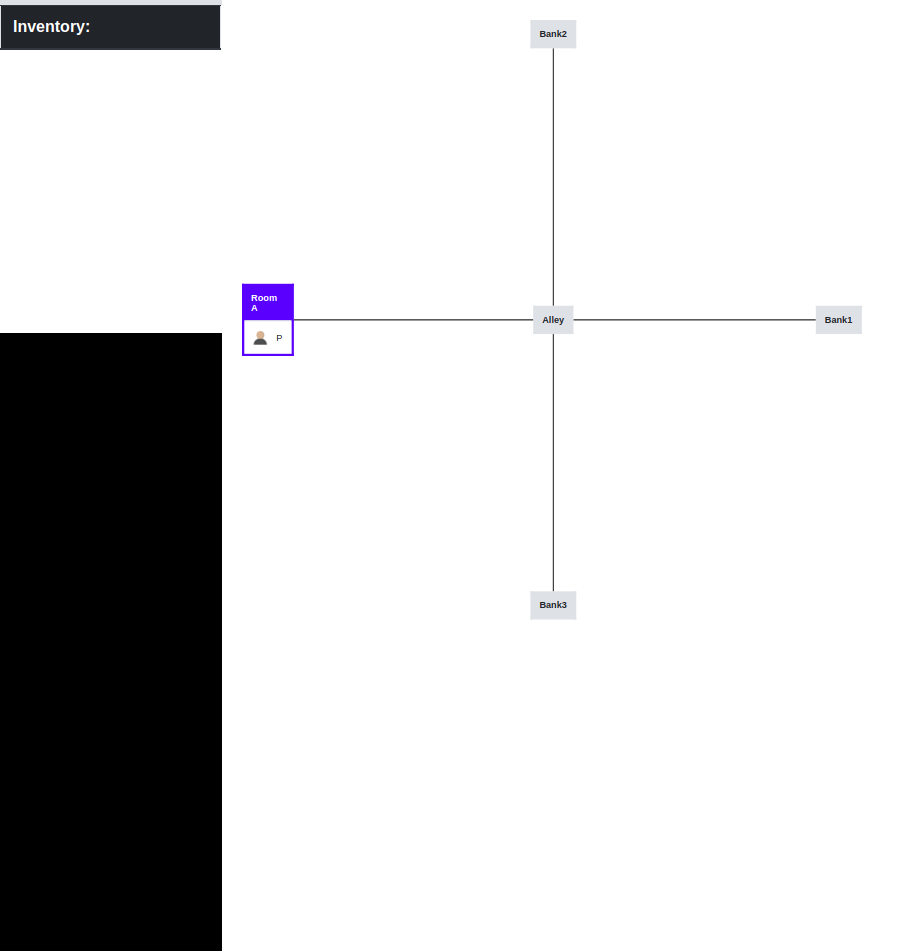

In [4]:
roomA = M.new_room("Room A")
alley = M.new_room("Alley")
bank1 = M.new_room("Bank1")
bank2 = M.new_room("Bank2")
bank3 = M.new_room("Bank3")
corridor = M.connect(roomA.east, alley.west)
corridor1 = M.connect(alley.east, bank1.west)
corridor1 = M.connect(alley.north, bank2.south)
corridor1 = M.connect(alley.south, bank3.north)
M.set_player(roomA)
M.render()

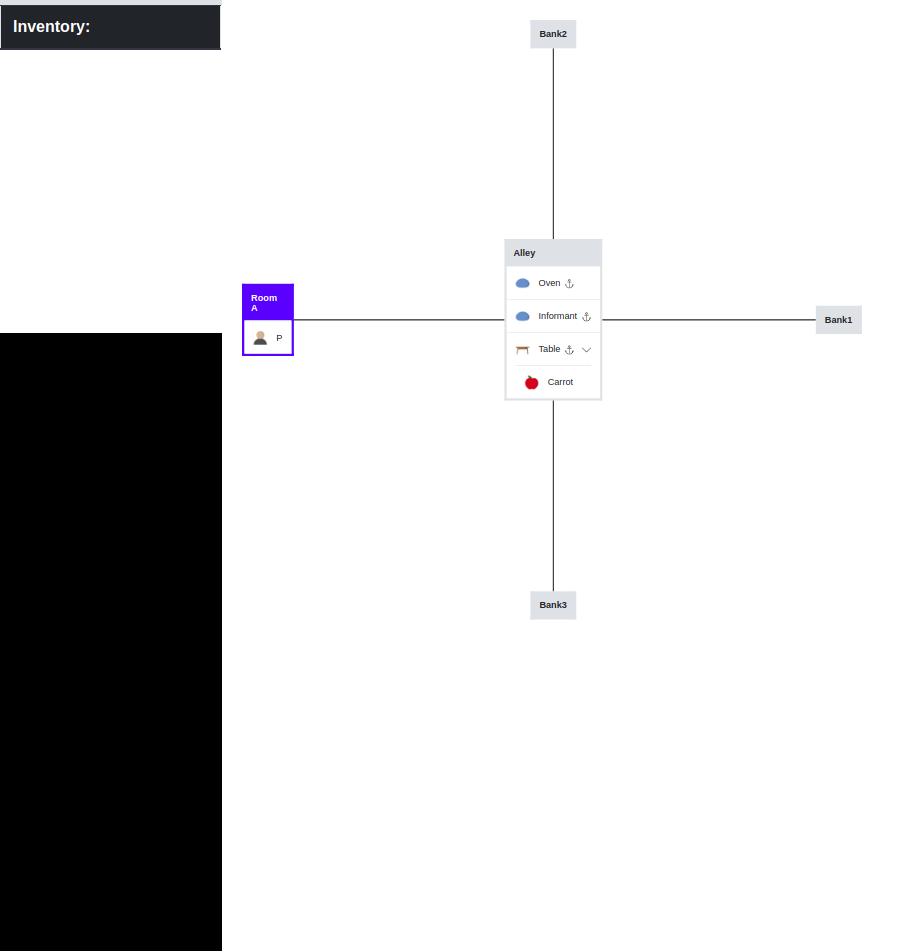

In [5]:
roomA.infos.desc = "You are in a road. Some mobs are planning to rob a bank. You need to stop them. Go east to the alley. You can find a person in the alley who has information about the roberry. Collect information from him and prevent the roberry."
alley.infos.desc = "There is a person beside the table in the alley. You can find an oven here as well."
supporter = M.new(type='s', name = "table")  # When not provided, names are automatically generated.
alley.add(supporter)  # Supporters are fixed in place.
supporter.infos.desc = "It is a metal sturdy table. There are some food on the table"
food = M.new(type="f", name = 'carrot') 
food.infos.desc = "It's carrot"
stove = M.new(type="oven", name = "oven")
stove.infos.desc = "this is an oven. you can cook your food"
supporter.add(food)  # When added directly to a room, portable objects are put on the floor.
#supporter.add(stove)
alley.add(stove)
person = M.new(type="pr", name = "informant")
person.infos.desc = "This person knows about the bank roberry. Do a favor for him. He will help you."
M.add_fact("not_asked", person)
alley.add(person)
M.add_fact("raw",food)
M.render()

In [6]:
@contextlib.contextmanager
def capture_stdout():
    # Capture stdout.
    stdout_bak = sys.stdout
    sys.stdout = out = io.StringIO()
    try:
        yield out
    finally:
        # Restore stdout
        sys.stdout = stdout_bak


def _compile_test_game(game):
    grammar_flags = {
        "theme": "house",
        "include_adj": False,
        "only_last_action": True,
        "blend_instructions": True,
        "blend_descriptions": True,
        "refer_by_name_only": True,
        "instruction_extension": []
    }
    rng_grammar = np.random.RandomState(1234)
    grammar = textworld.generator.make_grammar(grammar_flags, rng=rng_grammar)
    game.change_grammar(grammar)

    game_file = textworld.generator.compile_game(game)
    return game_file


def build_and_compile_no_quest_game(options: GameOptions):
    M = textworld.GameMaker()

    room = M.new_room()
    M.set_player(room)
    item = M.new(type="o")
    room.add(item)
    game = M.build()

    game_file = _compile_test_game(game, options)
    return game, game_file


def build_and_compile_super_hero_game():
    quest1_cmds = ["go east", "take carrot", "cook the carrot"]
    cook_carrot = M.new_event_using_commands(quest1_cmds)
    eating_carrot = Event(conditions={M.new_fact("consumed", food)})
    quest1 = Quest(win_events=[cook_carrot],
                   fail_events=[eating_carrot],
                   reward=2)
    
    quest2_cmds = quest1_cmds + ["ask informant"]
    quest2_actions = M.new_event_using_commands(quest2_cmds).actions
    ask_the_informant = Event(conditions={M.new_fact("asked", person)},
                              actions=quest2_actions)
    quest2 = Quest(win_events=[ask_the_informant],
                   fail_events=[eating_carrot])
    
#     ask_the_informant = M.new_event_using_commands(quest2_cmds)
#     quest2 = Quest(win_events=[ask_the_informant],
#                    fail_events=[eating_carrot],
#                    reward=2)

    M.quests = [quest1, quest2]
    game = M.build()
    game.main_quest = M.new_quest_using_commands(quest2_cmds)
    game_file = _compile_test_game(game)
    return game, game_file
    

In [7]:
game, game_file = build_and_compile_super_hero_game()